<a href="https://colab.research.google.com/github/duTianze/machine-learning/blob/master/MRI_SEG_4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 下载数据

In [30]:
!pip3 install kaggle
!kaggle
!echo "{\"username\":\"dutianze\",\"key\":\"ff2944c6219d449b37460827c4414422\"}" > /root/.kaggle/kaggle.json
!kaggle datasets download -d dutianze/processmri
!apt-get install zip
# !rm -rf __MACOSX
# !rm -rf MRI
!unzip -q ./processmri.zip

usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,config} ...
kaggle: error: too few arguments
processmri.zip: Skipping, found more recently modified local copy (use --force to force download)
Reading package lists... Done
Building dependency tree       
Reading state information... Done
zip is already the newest version (3.0-11build1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


## import

In [0]:
import numpy as np 
import random
import os, shutil
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import numpy as np
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.preprocessing.image import img_to_array

##全局变量

### BASE_DIR = ./MRI

### IMAGE_DIR = ./MRI/image

### MARKED_DIR = ./marked

### TRAIN_COUNT = 2268

### TEST_COUNT =  72

### SIZE = (512, 512)

##计算数据量并分出72个测试
可能需要配置主目录

In [32]:
BASE_DIR = './MRI'
IMAGE_DIR = os.path.join(BASE_DIR, 'image')
MARKED_DIR = os.path.join(BASE_DIR, 'marked')
file_list = os.listdir(IMAGE_DIR)
IMAGE_COUNT = len(file_list)
TEST_COUNT = 72
TRAIN_COUNT = IMAGE_COUNT - TEST_COUNT
print('image_count:' , IMAGE_COUNT)
print('train_count:' , TRAIN_COUNT)
print('test_count:' , TEST_COUNT)

image_count: 2340
train_count: 2268
test_count: 72


In [33]:
# 构建test目录
test_dir = os.path.join(BASE_DIR, 'test')
if os.path.isdir(test_dir):
  print('test_dir exists')
else:
  print('test_dir dir...')
  os.mkdir(test_dir)
  
TEST_IMAGE = os.path.join(BASE_DIR, 'test', 'image')
if os.path.isdir(TEST_IMAGE):
  print('TEST_IMAGE exists')
else:
  print('creating TEST_IMAGE...')
  os.mkdir(TEST_IMAGE)
  
TEST_MARKED = os.path.join(BASE_DIR, 'test', 'marked')
if os.path.isdir(TEST_MARKED):
  print('TEST_MARKED exists')
else:
  print('creating TEST_MARKED...')
  os.mkdir(TEST_MARKED)

test_dir dir...
creating TEST_IMAGE...
creating TEST_MARKED...


In [34]:
#移动文件 此操作不可恢复 失败需从头运行
file_list = os.listdir(IMAGE_DIR)
random.shuffle(file_list)
for i in range(TEST_COUNT):
    sample = file_list[i]
    image_file_dir = os.path.join(IMAGE_DIR, sample)
    marked_file_dir = os.path.join(MARKED_DIR, sample)
    shutil.move(image_file_dir, TEST_IMAGE)
    shutil.move(marked_file_dir, TEST_MARKED)
print('move finish')

move finish


In [58]:
ls -l ./MRI/image |grep "^-"|wc -l

2268


##展示图片

In [0]:
def show_image(file_name):
  base_dir1 = os.path.join('./MRI/image')
  base_dir2 = os.path.join('./MRI/marked')
  plt.figure(figsize=(15,15))
  img1 = Image.open(os.path.join(base_dir1, file_name))
  plt.subplot(221); plt.imshow(img1, cmap ='gray')
  img2 = Image.open(os.path.join(base_dir2, file_name))
  plt.subplot(222); plt.imshow(img2, cmap ='gray')
  plt.show()

In [0]:
def show_np(np):
  im = Image.fromarray(np)
  plt.figure(figsize=(15,15))
  plt.subplot(221)
  plt.imshow(im, cmap ='gray')
  plt.show()

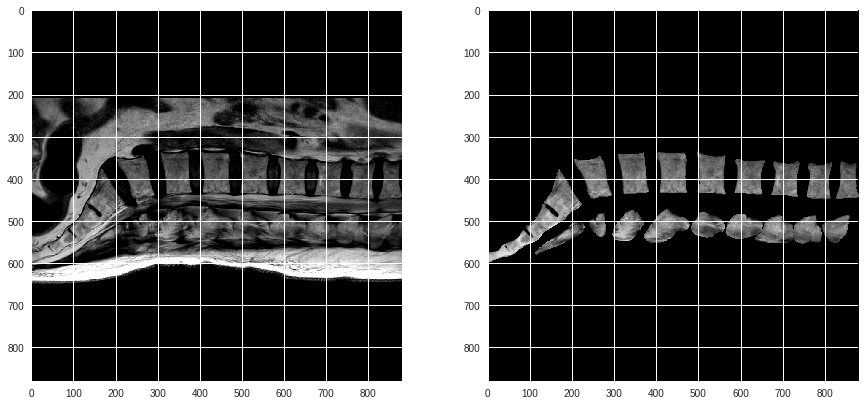

In [44]:
show_image('Case1.nii.gz_5.png')

##缩放数据

In [0]:
SIZE = (512, 512)
def resize_process(data):
    img = Image.open(data)
    img = img.resize(SIZE,Image.ANTIALIAS)
    return img

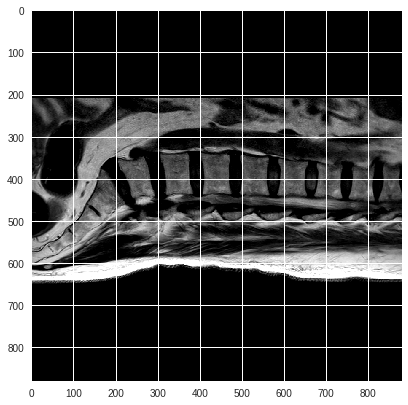

In [89]:
# 原图
show_np(np.array(Image.open('./MRI/image/Case1.nii.gz_4.png')))

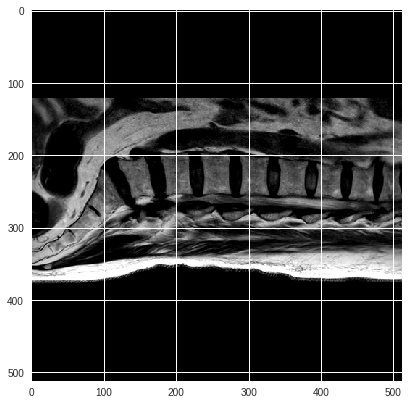

In [90]:
# 缩放到512*512的图
show_np(np.array(resize_process('./MRI/image/Case1.nii.gz_4.png')))

In [94]:
np.array(resize_process('./MRI/image/Case1.nii.gz_4.png')).shape

(512, 512)

##创建generate

In [0]:
def generate_data(directory, batch_size):
    i = 0
    file_list = os.listdir(directory)
    while True:
        image_batch = []
        marked_batch = []
        for b in range(batch_size):
            if i == len(file_list):
                i = 0
                random.shuffle(file_list)
            sample = file_list[i]
            i += 1
            
            file_dir_img = os.path.join(IMAGE_DIR, sample)
            file_dir_mark = os.path.join(MARKED_DIR, sample)
 
            im_array = np.array(resize_process(file_dir_img))
            image_batch.append(im_array.astype(float) / 255)
    
            mark_array = np.array(resize_process(file_dir_mark))
            marked_batch.append(mark_array.astype(float) / 255)

        yield np.array(image_batch).reshape(batch_size, SIZE[0], SIZE[1],1), np.array(marked_batch).reshape(batch_size, SIZE[0], SIZE[1],1)

In [96]:
a, b = next(generate_data(IMAGE_DIR, 4))
a.shape

(4, 512, 512, 1)

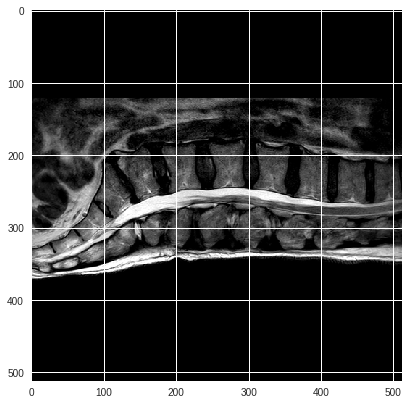

In [97]:
show_np(a[3].reshape(SIZE[0], SIZE[1]))

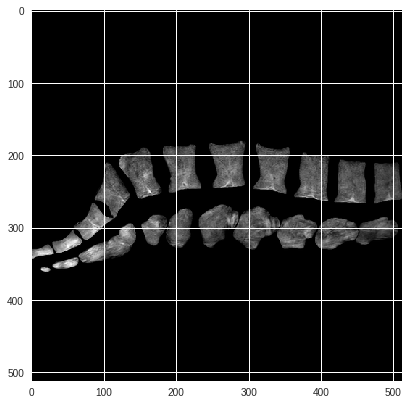

In [98]:
show_np(b[3].reshape(SIZE[0], SIZE[1]))

##构建网络

In [103]:
autoencoder = Sequential()

# Encoder Layers
autoencoder.add(Conv2D(512, (3, 3), activation='relu', padding='same', input_shape=(SIZE[0], SIZE[1], 1)))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))

# Decoder Layers
autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 512, 512, 512)     5120      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 256, 256, 512)     0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 256, 256, 128)     589952    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 128, 128, 64)      73792     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 64, 64, 64)        36928     
__________

## 训练模型

In [0]:
batch_size = 1
train_generator = generate_data(IMAGE_DIR, batch_size)
autoencoder.compile(optimizer=Adam(lr = 1e-4), loss='binary_crossentropy')

In [0]:
history = autoencoder.fit_generator(
    train_generator,
    steps_per_epoch = TRAIN_COUNT//batch_size,
    epochs=20,
    verbose=1)

Epoch 1/20
 176/2268 [=>............................] - ETA: 15:34 - loss: 0.1627

## 预测

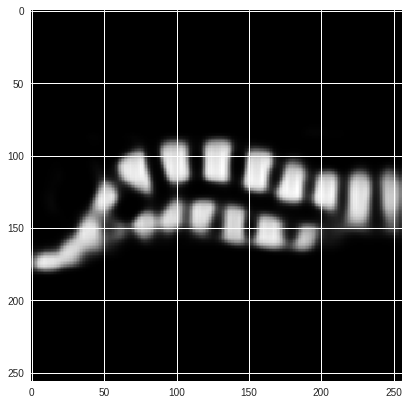

In [0]:
a, b = next(generate_data('./MRI', 4))
c = autoencoder.predict(a)
show_np(c[1].reshape(256,256))

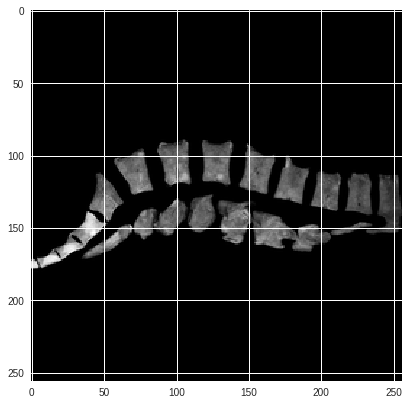

In [0]:
show_np(b[1].reshape(256,256))